## Resumo

Esse notebook foi feito para construir o MVP do Chamada Tech, um projeto que
tem como objetivo realizar um registro de presença inteligente através de
IA. Para tal, foram utilizados diferentes modelos de Machine Learning voltados
para o desafio de reconhecimento facial, criando uma pipeline de treinamento
com imagens do dataset Labelled Faces in the Wild (LFW).

<img width="480" height="480" alt="LFW" src="https://d1sr9z1pdl3mb7.cloudfront.net/wp-content/uploads/2015/12/25183714/LFW-facial-recognition-benchmark-database.png">

Além de ser explicado
todo o procedimento feito para processamento de imagens, foram feitas análises
de métricas para o problema de verificação de imagens (que se encaixa na
vertente de classificação) e quais os seus impactos de negócio para instituições
acadêmicas.

## Definições de Funções, classes e imports

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import random
import cv2
import os
import face_recognition

from datetime import datetime
from typing import List
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.datasets import fetch_lfw_pairs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
def get_filepaths(path, min_images = 0, max_images = 0, verbose=True, limit=-1):
    '''Dado um path de diretório contendo as imagens a serem utilizadas, retorna todos os paths das imagens'''
    target_names = {}
    filepaths = []
    max = 1
    for dirname, _, filenames in os.walk(path):
        if min_images > 0 and len(filenames) < min_images:
          continue
        if max_images > 0 and len(filenames) > max_images:
          continue

        target_name = os.path.basename(dirname).replace('_', ' ')

        for filename in filenames:
            if limit > -1 and max > limit:
                break
            if filename.endswith('.jpg'):
                filepaths.append(os.path.join(dirname, filename))
                # print(os.path.join(dirname, filename))
                target_names[len(filepaths) - 1] = target_name
            if limit > -1:
                max += 1

    if verbose:
      print(f"{len(filepaths)} paths de imagens encontrados")
      print(f"Foram encontradas imagens de {len(set(list(target_names.values())))} pessoas distintas")

    return filepaths, target_names

In [3]:
def show_imgs_with_bbox(all_filepaths, n_imgs = 3, n_cols = 3):
    filepaths = []
    random_indexes = random.sample(range(0, len(all_filepaths)), n_imgs)

    for rdn_idx in random_indexes:
      filepaths.append(all_filepaths[rdn_idx])

    for i, filepath in enumerate(filepaths, 1):
        image = cv2.imread(filepath)
        face_locations = face_recognition.face_locations(image)

        cv2.rectangle(image, (face_locations[0][3], face_locations[0][0]), (face_locations[0][1], face_locations[0][2]), (0, 0, 255), 2)
        cv2.imshow('Exemplo', image)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
def show_hog_example(filepaths):
  fig = plt.figure(figsize=(14, 10))

  img = imread(filepaths[10])
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                  	cells_per_block=(2, 2), visualize=True, channel_axis=-1)

  ax1 = plt.subplot(1, 2, 1)
  plt.imshow(img)
  ax1.set_xticks([])
  ax1.set_yticks([])


  ax2 = plt.subplot(1, 2, 2)
  plt.imshow(hog_image, cmap="gray")
  ax2.set_xticks([])
  ax2.set_yticks([])

  plt.show()

In [5]:
def verify(img1, img2):
    # cria o embedding dos pares de imagens a serem comparados
    image1_embeddings = face_recognition.face_encodings(img1)
    image2_embeddings = face_recognition.face_encodings(img2)

    # como o dataset de treino tem imagens com iluminação e angulos diferentes,
    # algumas vezes o modelo não consegue fazer o embedding de alguma
    # determinada imagem. Porém, para o escopo do projeto, esse não
    # seria um problema, já que o reconhecimento aconteceria em um
    # ambiente mais controlado (salas de aula), com os alunos olhando
    # diretamente para a câmera.
    if len(image1_embeddings) == 0 or len(image2_embeddings) == 0:
        return None

    img1_embedding = image1_embeddings[0]
    img2_embedding = image2_embeddings[0]

    # compara se as imagens são da mesma pessoa (1) ou não (0)
    matches = face_recognition.compare_faces([img1_embedding], img2_embedding)
    return 1 if matches[0] else 0
    

In [6]:
def predict_test_set(pairs: np.ndarray, labels: np.ndarray):
    predictions = []
    actuals = labels.tolist()
    for i in range(0, pairs.shape[0]):
        pair = pairs[i]
        # converte uma imagem com valores em float32 para uint8
        img1 = cv2.normalize(pair[0], None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
        img2 = cv2.normalize(pair[1], None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
        prediction = verify(img1, img2) # retorna 1 caso as imagens são da mesma pessoa, 0 caso contrário
        if prediction is None:
            actuals[i] = None
        else:
            predictions.append(prediction)
            
    actuals = list(filter(lambda v: v is not None, actuals))
    return predictions, actuals

In [7]:
def calculate_metrics(predictions, actuals):
    acc_score = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions)
    recall = recall_score(actuals, predictions)
    f1 = f1_score(actuals, predictions)
    
    return acc_score, precision, recall, f1

In [8]:
def show_confusion_matrix(predictions, actuals):
    cm = confusion_matrix(actuals, predictions)
    
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

In [9]:
class FacialRecognitionModel():
  def __init__(self):
    self.embeddings = []
    self.target_names = []

  def load_images(self, filepaths: List[str]) -> List[np.typing.NDArray[np.uint8]]:
    images = []

    for filepath in filepaths:
      img = cv2.imread(filepath)
      images.append(img)

    return images

  def create_embeddings(self, image: np.typing.NDArray[np.uint8], multiple = False):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    embeddings = face_recognition.face_encodings(image_rgb)

    if multiple:
      return embeddings

    return embeddings[0] if len(embeddings) > 0 else []

  def train(self, filepaths: List[str], target_names: List[str]):
    self.target_names = target_names
    images = self.load_images(filepaths)

    for i in range(len(images)):
      embedding = self.create_embeddings(images[i])
      if len(embedding) > 0:
        self.embeddings.append(embedding)
      else:
        print(f"Skipping embedding of {filepaths[i]}")
        del self.target_names[i]

  def find_matching_image(self, new_embedding):
    name = "Unknown"
    matches = face_recognition.compare_faces(self.embeddings, new_embedding)
    face_distances = face_recognition.face_distance(self.embeddings, new_embedding)

    match_idx = np.argmin(face_distances)
    if matches[match_idx]:
        name = self.target_names[match_idx]
        return name


In [10]:
def confirm_attendance(name: str, current_date: str, current_time: str):
    with open('attendance.csv', 'r+') as f:
        duplicate = True
        students = f.readlines()
        names = []
        
        for student in students:
            row = student.split(',')
            names.append(row[0])
            
        if name not in names:
            duplicate = False
            f.writelines(f"\n{name},{current_date},{current_time}")
            
    return duplicate
        

In [11]:
def real_time_face_recognition(filepaths: List[str], target_names, model):
    # Captura de frames da câmera
    video_capture = cv2.VideoCapture(0)
    all_students = []

    while True:
        ret, frame = video_capture.read()
        
        small_frame = cv2.resize(frame, None, fx=0.25, fy=0.25)
            
        small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        
        # Detecção de rostos no frame
        face_locations = face_recognition.face_locations(small_frame)
        # Criação do embedding no frame
        embeddings = face_recognition.face_encodings(small_frame, face_locations)

        frame_matches = []
        
        for embedding in embeddings:
            match = model.find_matching_image(embedding)
            if match is not None:
                frame_matches.append(match)
                
                now = datetime.now()
                current_date = now.strftime('%d-%m-%Y')
                current_time = now.strftime('%H:%M:%S')
                
                duplicate = confirm_attendance(match, current_date, current_time)
                if not duplicate:
                    new_student = {'nome': match, 'data': current_date, 'horario': current_time}
                    all_students.append(new_student)
                    print(new_student)
                
            
        for (top, right, bottom, left), name in zip(face_locations, frame_matches):
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4
    
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
        
        cv2.imshow('Chamada Tech', frame)
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()


## Setup

In [12]:
PATH = r"/home/lucasfernandes/dev/data/lfw/lfw-deepfunneled/lfw-deepfunneled/"

In [13]:
filepaths, target_names = get_filepaths(PATH, min_images=2, max_images=3)

2431 paths de imagens encontrados
Foram encontradas imagens de 1070 pessoas distintas


## Pipeline de Treinamento

A pipeline de treinamento usada para reconhecimento de imagens é composta pelos
seguintes passos:


1.   Detecção de faces em imagens
2.   Detecção dos principais pontos da face das pessoas
3.   Mapeamento das faces para vetores de 128 características, também chamado de embedding

Cada um desses passos utiliza um modelo de Machine Learning distinto, os quais
serão explicados mais abaixo à medida que forem utilizados. Para facilitar o
processo de treinamento, foi utilizada uma biblioteca chamada
[face_recognition](https://github.com/ageitgey/face_recognition), um wrapper
para os diferentes modelos que serão utilizados ao longo do
notebook. A pipeline foi inspirada nesse [artigo](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78), escrito pelo próprio autor do face_recognition. Já que serão utilizados
modelos pré-treinados, esse notebook se utiliza de Transfer Learning.

---

Primeiramente, deve ser feita a detecção de faces nas imagens. Essa etapa é
bastante importante para eliminar características indesejáveis para o escopo de
verificação facial, como roupas, o ambiente em que o indivíduo se encontra,
entre outros. Para a implementação dessa etapa, foi utilizado o [Histogram of
Oriented Gradients](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) (HOG). Resumidamente, esse modelo converte cada pixel de uma imagem em
vetores (chamados de gradientes) que apontam para o pixel vizinho mais escuro.
Após todos os gradientes serem calculados, temos uma representação de contraste
e brilho de uma imagem, o que facilita na detecção de características de rostos, como a delineação do rosto, posição dos olhos, nariz e boca, entre outros. Abaixo é mostrado um exemplo de resultado da aplicação do HOG à uma
das imagens do dataset.

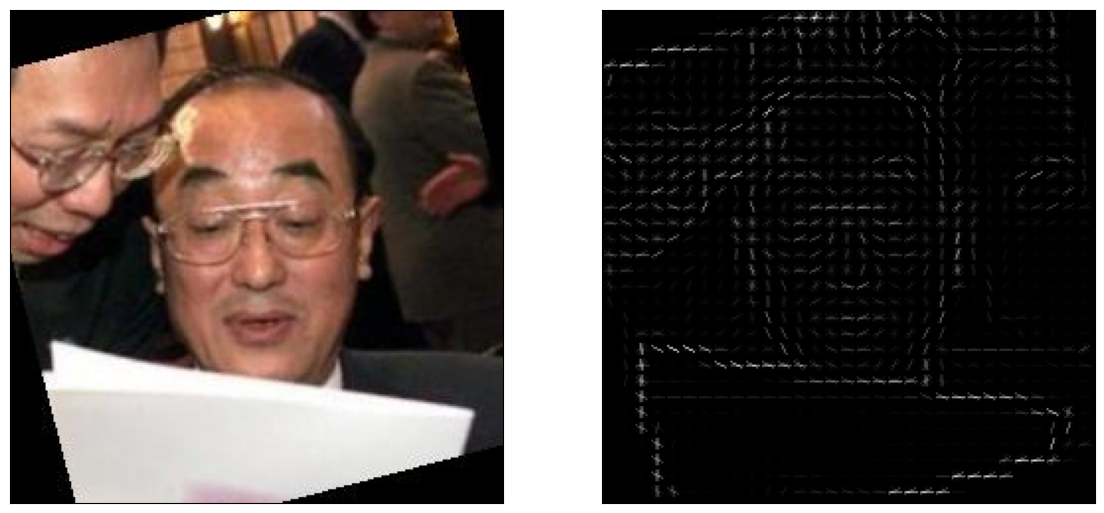

In [14]:
show_hog_example(filepaths)

Como já foi falado, foi utilizado um modelo pré-treinado de HOG da biblioteca
face_recognition, o qual já detecta os limites do rosto em imagens para que
sejam feitas caixas delimitadoras ao redor da face

In [15]:
image = face_recognition.load_image_file(filepaths[0])
face_locations = face_recognition.face_locations(image)
face_locations

[(80, 175, 187, 67)]

Exemplo de três imagens aleatórias com caixas delimitadores calculadas pelo HOG.


In [16]:
show_imgs_with_bbox(filepaths)

Detectados os rostos, o segundo passo da pipeline é a detecção dos principais pontos da face das pessoas, como a posição dos olhos, nariz, boca, contorno da face, etc. Esse passo é importante, pois nem todos os rostos das imagens podem estar no mesmo ângulo, por isso, para aperfeiçoar o passo seguinte, é preciso
centralizar os rostos das pessoas, para que fiquem aproximadamente na mesma posição. Para tal, é utilizado o modelo de [facial landmark estimation](https://www.csc.kth.se/~vahidk/papers/KazemiCVPR14.pdf), no qual são utilizadas várias árvores de regressão para estimar os marcos da face a partir de uma imagem, no qual é utilizado o método de Ensemble Learning do tipo Boosting, minimizando a soma dos erros ao quadrado (Sum of Squared Erros) e provendo resultados precisos e rápidos, capazes de executar em tempo real. O próprio face_recognition utiliza um modelo pré-treinado do [dlib](https://pypi.org/project/dlib/), fornecendo uma
função wrapper para retornar os principais 68 pontos de uma face dada uma imagem.

In [17]:
landmarks = face_recognition.face_landmarks(image)

Objeto retornado do face_landmarks

In [25]:
print(landmarks)

[{'chin': [(83, 115), (83, 127), (85, 139), (88, 151), (92, 163), (98, 174), (105, 184), (115, 192), (127, 194), (140, 192), (153, 185), (165, 177), (174, 166), (180, 154), (183, 141), (184, 127), (185, 113)], 'left_eyebrow': [(88, 103), (93, 98), (99, 97), (107, 98), (114, 100)], 'right_eyebrow': [(134, 99), (142, 95), (151, 94), (160, 97), (167, 102)], 'nose_bridge': [(124, 110), (123, 119), (122, 128), (121, 138)], 'nose_tip': [(115, 142), (119, 144), (123, 146), (128, 144), (133, 142)], 'left_eye': [(98, 113), (103, 110), (109, 110), (114, 113), (109, 114), (103, 115)], 'right_eye': [(139, 112), (144, 110), (150, 110), (156, 112), (151, 114), (145, 114)], 'top_lip': [(108, 157), (114, 154), (120, 153), (125, 154), (131, 153), (139, 154), (147, 158), (144, 158), (131, 156), (125, 157), (120, 156), (111, 157)], 'bottom_lip': [(147, 158), (140, 164), (132, 167), (125, 168), (120, 167), (114, 164), (108, 157), (111, 157), (120, 162), (125, 163), (131, 162), (144, 158)]}]


Exemplo de predições dos marcos da face de uma das imagens do dataset

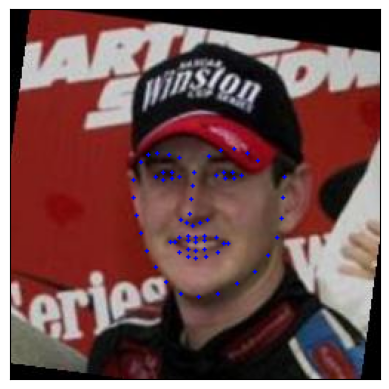

In [32]:
for k, v in landmarks[0].items():
    for (x, y) in v:
        cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

Encontrados os marcos da face, a imagem é redimensionada e alinhada, preparada para o próximo passo da pipeline.

O terçeiro e último passo é de classificar as faces em si. Para isso, é utilizado o [FaceNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/1A_089.pdf), um modelo de Rede Neural Convolucional (CNN) que otimiza o processo de extrair características de rostos, transormando-os em vetores de 128 dimensões (chamados de embeddings) que podem ser comparados entre si através de diversos métodos, a fim de estimar quais embeddings são mais parecidos através de suas distâncias em um espaço vetorial. O treinamento do FaceNet é feito através de uma Triplet Loss Function, ou seja, a base de treinamento é dividida em trios de imagens: uma imagem âncora (imagem de referência), uma imagem positiva (mesma pessoa que a imagem âncora) e uma imagem negativa (pessoa diferente da imagem âncora).

<img width="480" height="480" alt="LFW" src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/6439367f6d20a585ff503685_face%20recgonition%20model.webp">

Ao longo do treinamento, o modelo cria uma função com pesos que têm como objetivo maximizar as distâncias entre os embeddings de pessoas diferentes e minimizar as distâncias entre embeddings da mesma pessoa. Esses pesos então são modificados ao longo do processo, até chegarem em um valor final, criando assim uma função que reconhece quais embeddings representam a mesma face ou não.  

<img width="480" height="480" alt="LFW" src="https://miro.medium.com/v2/resize:fit:1400/1*rDBbSTCvh0xnu2otaW9cyw.png">

O face_recognition conta com um modelo pré-treinado do FaceNet, o qual retorna um emdedding da imagem passada como parâmetro

In [11]:
encoding = face_recognition.face_encodings(image)
encoding

[array([-6.55719787e-02,  1.23412229e-01,  3.72027606e-02, -5.75256422e-02,
        -1.73095793e-01, -7.23432237e-03, -5.84207550e-02, -1.45725086e-01,
         1.65437698e-01, -1.38640419e-01,  1.29213631e-01, -9.10558626e-02,
        -2.23877013e-01,  1.06498227e-01, -1.89422872e-02,  8.95943642e-02,
        -8.46256912e-02, -1.69529498e-01, -1.01852611e-01, -9.35371295e-02,
         1.07650962e-02,  9.37333629e-02, -4.67421301e-02,  5.83162345e-02,
        -1.18241742e-01, -2.98066795e-01, -1.06720470e-01, -4.97180223e-02,
         1.06875762e-01, -1.07282409e-02, -2.28978358e-02, -1.00323523e-03,
        -1.19459033e-01, -3.58472690e-02,  4.57358584e-02,  3.35988253e-02,
        -8.36552158e-02, -8.19446146e-02,  2.27224737e-01, -2.98165604e-02,
        -2.15473220e-01,  2.76043247e-02,  7.42847621e-02,  2.17273116e-01,
         1.88376859e-01,  8.06029141e-03,  6.64406046e-02, -1.33472681e-01,
         1.26965195e-01, -2.51291066e-01,  9.22287703e-02,  1.57370433e-01,
         1.1

Portanto, para que seja feito o reconhecimento facial, basta que seja dada uma nova imagem como input. Essa imagem será convertida em um embedding e então comparada com os demais embeddings previamente cadastrados.

## Métricas

A seguir, são avaliadas algumas métricas para o contexto de reconhecimento facial, o qual se encaixa em um problema de classificação. A avaliação foi feita da seguinte maneira: foram carregados vários pares de imagens do dataset Labelled Faces in the Wild, cada par pode consistir de imagens da mesma pessoa, ou de pessoas diferentes, e a tarefa do modelo é classificar se o par de imagens pertencem de fato a mesma pessoa ou não.

In [36]:
fetch_lfw_pairs = fetch_lfw_pairs(subset = 'test', color = True, resize = 1)
pairs = fetch_lfw_pairs.pairs
labels = fetch_lfw_pairs.target

In [37]:
predictions, actuals = predict_test_set(pairs, labels)

Após a predição, podemos ver algumas métricas abaixo. Pode-se perceber que: o modelo é bastante preciso com relação à identificação de rostos, havendo uma boa precisão, o que significa que o modelo tem uma alta taxa de acerto com relação ao que predisse; apresenta também uma alta cobertura, ou seja, tem uma boa taxa de acerto tanto para diferenciar rostos diferentes quanto para identificar rostos das mesmas pessoas; além de ter uma ótima acurácia, tendo uma taxa de acerto grande em relação ao total. 

In [38]:
acc_score, precision, recall, f1 = calculate_metrics(predictions, actuals)

print(f"Acurácia: {acc_score}")
print(f"Precisão: {precision}")
print(f"Cobertura: {recall}")
print(f"F1 Score: {f1}")

Acurácia: 0.9848661233993015
Precisão: 0.986046511627907
Cobertura: 0.9837587006960556
F1 Score: 0.9849012775842044


É evidente que em um contexto como o de sistema de registro de chamadas que um aluno que está presente na sala seja corretamente identificado, pois caso contrário, poderá receber faltas injustamente. Por isso, uma das métricas mais importantes a se levar em consideração é o chamado False Rejection Rate (taxa de falsas rejeições), o qual é calculado da seguinte maneira: 
$$\frac{\text{falsos negativos}}{\text{total de identificações}}$$
Por causa desse cenário, a equipe decidiu por não automatizar totalmente o sistema de registro de chamadas, ainda dando controle aos professores para editar as faltas dos alunos após a execução de uma chamada assíncrona, na qual o professor estabelecerá uma janela de tempo (5 minutos, por exemplo) para que os alunos se identifiquem em um totem, e após o final dessa chamada, o professor ainda poderá verificar modificar o registro de chamadas dos alunos caso haja alguma falha eventual. Outras formas de mitigação dos erros no processo foram pensados também, como a notificação dos alunos que seu registro de chamada foi feito com sucesso, entre outros.

---

Outra métrica que foi ponderada foi a False Acceptance Rate (taxa de falsas aceitações), o que implicaria em um aluno sendo identificado como outro. Essa métrica é calculada da seguinte maneira:
$$\frac{\text{falsos positivos}}{\text{total de identificações}}$$
Essa é outra métrica importante, pois um aluno poderia erroneamente ser reconhecido como outro, não sendo contabilizada sua presença na chamada. Apesar da solução do projeto não ter como objetivo automatizar totalmente o processo de chamadas, havendo alternativas para mitigar esses erros, esse é um ponto de atenção para o sistema. 

Podemos ver que tanto a taxa de falsas rejeições como a taxa de falsas aceitações foram bem baixas na base de teste, o que pode ser um bom indício de que o modelo é bastante apropriado para o problema.

In [44]:
cm = confusion_matrix(actuals, predictions)
false_negatives = cm[1][0]
false_positives = cm[0][1]
total = cm.sum()

FRR = false_negatives / total
FAR = false_positives / total

print(f"False Rejection Rate: {FRR}")
print(f"False Acceptance Rate: {FAR}")

False Rejection Rate: 0.008149010477299184
False Acceptance Rate: 0.006984866123399301


Matriz de confusão do modelo após a classificação na base de teste

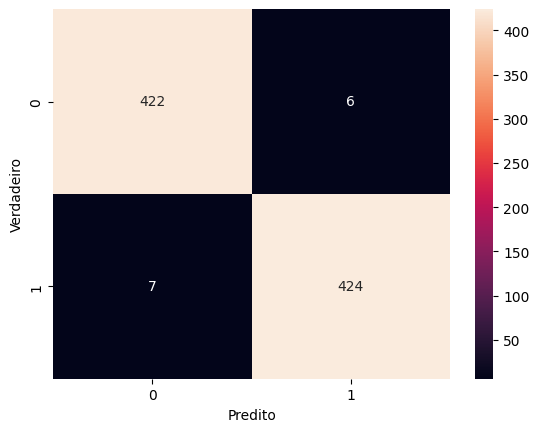

In [40]:
show_confusion_matrix(predictions, actuals)

## Implementação do MVP

In [17]:
# PATH = r"/home/lucasfernandes/dev/data/lfw/lfw-deepfunneled/lfw-deepfunneled/"
PATH = r"/home/lucasfernandes/dev/data/test_database/"

In [18]:
filepaths, target_names = get_filepaths(PATH, min_images=1, max_images=1, limit=50)

7 paths de imagens encontrados
Foram encontradas imagens de 7 pessoas distintas


In [19]:
model = FacialRecognitionModel()
model.train(filepaths, target_names)

In [ ]:
# DEBUG
# print(model.target_names)

In [21]:
real_time_face_recognition(filepaths, target_names, model)